# Transformée de Laplace inverse

## Introduction

La résolution d'équations différentielles linéaires peut s'effectuer en s'aidant de la transformée de Laplace. Via cette méthode, on accède dans un premier temps à la transformée de Laplace de la solution, qui se présente pour l'essentiel sous la forme d'une fraction rationnelle d'une variable complexe $p$.

Pour revenir à l'expression temporelle de la solution, il faut procéder à la **décomposition en éléments simples** de la fraction rationnelle en $p$, de sorte qu'apparaissent des termes élémentaires de la forme $\dfrac{K}{(p-a)^n}$ (dans le corps des complexes) pour lesquels l'expression temporelle associée $K\dfrac{t^{n-1}e^{at}\theta(t)}{(n-1)!}$ est connue.

L'idée ici est d'illustrer les méthodes de calcul via le package **sympy** de calcul symbolique. Mais il reste préférable de pouvoir **mener ces calculs avec un crayon et un papier**.

La validation s'effectuera avec la fonction **impulse** du package **scipy.signal**.

## Les packages utiles

In [1]:
import sympy as sp
import numpy as np
from scipy.signal import impulse
import matplotlib.pyplot as plt
from IPython.display import display

## Définition de $H(p)$ sous forme littérale

In [2]:
p, t, G = sp.symbols('p, t, G')
Gn = [(G, 5)]
P = sp.IndexedBase('P')
Z = sp.IndexedBase('Z')
Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.7)]
# Autres essais à tester
# Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.4)]
# Pn = [(P[0], 0), (P[1], -0.8), (P[2], -0.4)]
OPn = [1, 3, 1]
Zn = [(Z[0], 0.1), (Z[1], 0.2)]
OZn = [1, 1]

In [3]:
H = Gn[0][0]
for k in range(len(Pn)):
    H = H/(p - Pn[k][0])**OPn[k]
for k in range(len(Zn)):
    H = H*(p - Zn[k][0])**OZn[k]
display(H)
display(H.subs(Pn).subs(Zn).subs(Gn))

G*(p - Z[0])*(p - Z[1])/((p - P[0])*(p - P[1])**3*(p - P[2]))

5*(p - 0.2)*(p - 0.1)/((p + 0.5)*(p + 0.7)*(p + 0.8)**3)

## La fonction qui travaille sur l'expression littérale de $H(p)$

In [4]:
def inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t):
    A = sp.IndexedBase('A')
    H = Gn[0][0]
    for k in range(len(Pn)):
        H = H/(p - Pn[k][0])**OPn[k]
    for k in range(len(Zn)):
        H = H*(p - Zn[k][0])**OZn[k]
    display(H)
    An = []
    h = 0
    tl = 0
    for k in range(len(Pn)):
        display(Pn[k][0])
        N = OPn[k]
        Fn = H
        for n in range(N, 0, -1):
            an = (Fn*(p-Pn[k][0])**n).simplify()
            an = an.subs(p, Pn[k][0])
            an_num = an.subs(Zn).subs(Pn).subs(Gn).simplify()
            print('degré', n, 'coeff', an_num)
            An.append((A[k, n], an_num))
            h = h+A[k, n]*t**(n-1)*sp.exp(Pn[k][0]*t)/sp.factorial(n-1)
            tl = tl+A[k, n]/(p - Pn[k][0])**n
            Fn = (Fn-an/(p-Pn[k][0])**n).expand()
    return An, h, tl

## Test de la fonction pour obtenir $h(t)$ sous forme littérale, puis numérique

In [5]:
An, h, tl = inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t)
display(h)
display(h.subs(An).subs(Pn))
display(tl)
display(tl.subs(An).subs(Pn))

G*(p - Z[0])*(p - Z[1])/((p - P[0])*(p - P[1])**3*(p - P[2]))

P[0]

degré 1 coeff 388.888888888889


P[1]

degré 3 coeff 150.000000000000
degré 2 coeff 1683.33333333345
degré 1 coeff 17611.1111113153


P[2]

degré 1 coeff -18000.0000000000


t**2*exp(t*P[1])*A[1, 3]/2 + t*exp(t*P[1])*A[1, 2] + exp(t*P[0])*A[0, 1] + exp(t*P[1])*A[1, 1] + exp(t*P[2])*A[2, 1]

74.9999999999999*t**2*exp(-0.8*t) + 1683.33333333345*t*exp(-0.8*t) + 17611.1111113153*exp(-0.8*t) - 18000.0*exp(-0.7*t) + 388.888888888889*exp(-0.5*t)

A[2, 1]/(p - P[2]) + A[1, 1]/(p - P[1]) + A[1, 2]/(p - P[1])**2 + A[1, 3]/(p - P[1])**3 + A[0, 1]/(p - P[0])

17611.1111113153/(p + 0.8) + 1683.33333333345/(p + 0.8)**2 + 150.0/(p + 0.8)**3 - 18000.0/(p + 0.7) + 388.888888888889/(p + 0.5)

## Test de la méthode **apart** (ne fonctionne pas avec l'exemple)

In [6]:
display(H.subs(Zn).subs(Pn).subs(Gn).apart(p))

0.970873786407767*(1.0*p - 0.2)*(1.0*p - 0.1)/(0.194174757281553*p**5 + 0.699029126213592*p**4 + 1.0*p**3 + 0.709902912621359*p**2 + 0.24978640776699*p + 0.0347961165048544)

## Test de la méthode **inverse_laplace_transform** (ne fonctionne pas avec l'exemple)

In [7]:
display(sp.inverse_laplace_transform(H.subs(Zn).subs(Pn).subs(Gn), p, t))

0.1*(0.519744920670958*(-10.6872176779083 + 0.00161275984444836*I)*(-4.32693725476688 + 0.000149252064881055*I)*(0.999983685238538 - 9.4198855801913e-6*I)*(0.999999998946147 - 1.88415961675395e-5*I)*(1.06862110094624 - 1.31664241588824e-5*I)*(1.29804041118826 - 2.58461887125932e-5*I)*(26531.9020491188 + 15320.4238101107*I)*(-I*exp(-0.799990578167577*t)*sin(1.6321106082868e-5*t) + exp(-0.799990578167577*t)*cos(1.6321106082868e-5*t))*gamma(-3.26422121657361e-5*I) + 0.519744920670958*(-10.6872176779083 - 0.00161275984444836*I)*(-4.32693725476688 - 0.000149252064881055*I)*(0.999983685238538 + 9.4198855801913e-6*I)*(0.999999998946147 + 1.88415961675395e-5*I)*(1.06862110094624 + 1.31664241588824e-5*I)*(1.29804041118826 + 2.58461887125932e-5*I)*(26531.9020491188 - 15320.4238101107*I)*(I*exp(-0.799990578167577*t)*sin(1.6321106082868e-5*t) + exp(-0.799990578167577*t)*cos(1.6321106082868e-5*t))*gamma(3.26422121657361e-5*I) + 0.720834316205562*(-1226572.21459149 + 708233.752680998*I)*(-26533.0564

## Utilisation du package **scipy.signal** pour validation

In [8]:
N = sp.fraction(H)[0].subs(Zn).subs(Gn)
D = sp.fraction(H)[1].subs(Pn)
coeffD = np.array(sp.Poly(D).coeffs(), dtype=float)
coeffN = np.array(sp.Poly(N).coeffs(), dtype=float)
print(coeffN)
print(coeffD)

[ 5.  -1.5  0.1]
[1.     3.6    5.15   3.656  1.2864 0.1792]


## Bilan avec comparaison

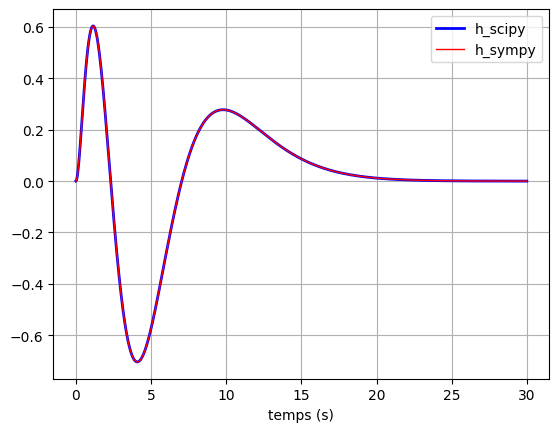

In [9]:
tps = np.arange(0, 30, 0.01)
_, h_scipy = impulse((coeffN, coeffD), T=tps)
h_sympy = np.real(sp.lambdify(t, h.subs(An).subs(Pn), 'numpy')(tps))
plt.plot(tps, h_scipy, 'b', lw=2, label='h_scipy')
plt.plot(tps, h_sympy, 'r', lw=1, label='h_sympy')
plt.grid('on')
plt.xlabel('temps (s)')
plt.legend()
plt.show()

## Méthodes de calcul

### Cas d'un pôle $p_0$ simple

$$F(p)=\dfrac{P(p)}{Q(p)}=\dfrac{P(p)}{B(p)(p-p_0)}=K(p)+\dfrac{a_1}{(p-p_0)}$$

$$a_1=\dfrac{P(p_0)}{B(p_0)}=F(p)(p-p_0)|_{p=p_0}$$

### Cas d'un pôle $p_0$ d'ordre de multiplicité N supérieur à 1

Première étape pour récupérer le terme de plus haut degré :

$$F(p)=\dfrac{P(p)}{Q(p)}=\dfrac{P(p)}{B(p)(p-p_0)^N}=K(p)+\Sigma_{n=1}^N\dfrac{a_n}{(p-p_0)^n}$$

$$a_N=\dfrac{P(p_0)}{B(p_0)}=F(p)(p-p_0)^N|_{p=p_0}$$

Par récurrence sur N étapes incluant la première étape :

* Initialisation

$$F_n(p)=F(p)$$

* Pour $n$ variant de $N$ à $1$ :

$$a_n=F_n(p)(p-p_0)^n|_{p=p_0}$$

$$F_n(p)=F_n(p)-\dfrac{a_n}{(p-p_0)^n}$$
